## 03 - Modelling

## Optional - Colab Setup

In [ ]:
def upgrade_runtime_ram():
    meminfo = subprocess.getoutput('cat /proc/meminfo').split('\n')

    memory_info = {entry.split(':')[0]: int(entry.split(':')[1].replace(' kB','').strip()) for entry in meminfo}

    if memory_info['MemTotal'] > 17000000:
        return

    a = []
    while(1):
        a.append('1')

In [ ]:
def restart_runtime():
    os.kill(os.getpid(), 9)

In [ ]:
def setup_rapids():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    device_name = pynvml.nvmlDeviceGetName(handle)
    if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
        print("Wrong GPU - Restarting Runtime")
        restart_runtime()


    # clone RAPIDS AI rapidsai-csp-utils scripts repo
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git

    # install RAPIDS
    !bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13


    # set necessary environment variables 
    dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
    sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
    sys.path

    # update pyarrow & modules 
    exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [ ]:
def setup_conda():
    if not 'Miniconda3-4.5.4-Linux-x86_64.sh' in os.listdir():
        !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local

    if not ('EPFL-Capstone-Project' in os.listdir()) and (os.getcwd().split('/')[-1] != 'EPFL-Capstone-Project'):
        !git clone https://github.com/helmigsimon/EPFL-Capstone-Project  
    if 'EPFL-Capstone-Project' in os.listdir():
        os.chdir('EPFL-Capstone-Project')

    !conda env create -f environment.yml
    !conda activate exts-ml

In [ ]:
def setup_drive():
    #Mounting Google Drive
    global drive
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
try:
    import sys,os,subprocess
    
    upgrade_runtime_ram()
    setup_drive()

    #Setting up PyPi Packages
    !pip install geopandas sparse-dot-topn pdpipe category-encoders catboost
    import geopandas as gpd
    import sparse_dot_topn.sparse_dot_topn as ct
    import pdpipe as pdp
    import category_encoders

    #Setting up Conda Packages
    setup_conda()
    
    #Initializing NLTK
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')
    
    #Setting up RAPIDS AI
    import pynvml
    setup_rapids()
    
    from cuml import UMAP
    
except ModuleNotFoundError as e:
    print(e)
    print('Not in colab environment, continuing to run locally')
    from umap import UMAP

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split,  StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
tqdm.pandas()

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [4]:
from lib.transformers import *
from lib.pipelines import *
from lib.processing import save_to_pkl, load_from_pkl
from lib.visualization import GridSearchPlotter
from data.util.paths import DATA_PATH

In [5]:
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [6]:
try:
    from cuml import LinearRegression, RandomForestRegressor
except ModuleNotFoundError:
    pass

In [7]:
from catboost import CatBoostRegressor

## Loading Data

In [8]:
df = load_from_pkl('final',DATA_PATH)

In [9]:
col_set = {
    'format': {
        'description': 'format_description_', 
        'name': 'format_name_', 
        'text': ('format_text_clean'),
        'quantity': ('format_quantity')
    },
    'geography': {
        'superregion': 'superregion_',
        'region': 'region_',
        'country': 'country_'
    },
    'timeperiod': {
        'period': 'period_',
        'era': 'era_'
    },
    'genre': 'genre_',
    'style': 'style_',
    'null': None,
    'indicator': lambda x: x.max() == 1 and x.min() == 0,
    'image_embedding': 'image_umap_'
}
column_store = ColumnStore()
column_store.fit(df,col_set)

## Preparing for Machine Learning

In [10]:
X_tr, X_te, y_tr, y_te = train_test_split(df.drop('market_value',axis=1),df.market_value)

In [11]:
df_sample = pd.concat([X_tr,y_tr],axis=1).sample(frac=0.1)
X_tr_sample = df_sample.drop('market_value',axis=1)
y_tr_sample = df_sample['market_value']

In [12]:
del df

## Setting up Dummy Regression for baseline

In [ ]:
dummy_regressor = DummyRegressor(strategy='mean')

In [ ]:
dummy_regressor.fit(X_tr,np.log(y_tr).values)

In [ ]:
dummy_pred = dummy_regressor.predict(X_te)

In [ ]:
r2_score(y_te,np.exp(dummy_pred))

In [ ]:
mean_absolute_error(y_te,np.exp(dummy_pred))

Ridge Regression

In [ ]:
full_information_transformer = ColumnTransformer(transformers=[
    ('units_for_sale_imputer', SimpleImputer(strategy='constant',fill_value=0),['units_for_sale']),
    ('average_rating_imputer', SimpleImputer(strategy='mean'),['average_rating']),
    ('year_encoder', OneHotEncoder(dtype=np.uint8), ['year'])
], remainder='passthrough')

In [ ]:
record_store_lr_transformer = ColumnTransformer(transformers=[
    ('year_encoder', OneHotEncoder(dtype=np.uint8,handle_unknown='ignore'), ['year'])
], remainder='passthrough')

In [ ]:
record_store_lr_removal_columns = [
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','country','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title',
    ]

In [ ]:
record_store_lr_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','master_id','format_name'])),
    ('record_store_column_remover', ColumnRemover(record_store_lr_removal_columns)),
    ('preprocessing',record_store_lr_transformer),
    ('scaler', StandardScaler()),
    ('lr', GridSearchCV(
        LinearRegression(),
        param_grid={
            'normalize':[False,True]
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
    ))
])

In [ ]:
record_store_lr_pipe.fit(X_tr,np.log(y_tr).values)

In [ ]:
record_store_lr_pipe['lr'].best_score_

In [ ]:
lr_pred = record_store_lr_pipe.predict(X_te)

In [ ]:
r2_score(y_te,np.exp(lr_pred))

In [ ]:
mean_absolute_error(y_te,np.exp(lr_pred))

In [ ]:
from cuml import Ridge

In [ ]:
record_store_ridge_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id'])),
    ('record_store_column_remover', ColumnRemover(record_store_lr_removal_columns)),
    ('preprocessing',record_store_lr_transformer),
    ('scaler', StandardScaler()),
    ('ridge', GridSearchCV(
        Ridge(normalize=False,solver='eig'),
        param_grid={
            'alpha': np.linspace(1e-2,1e3,20),
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
        return_train_score=True
    ))
])

In [ ]:
record_store_ridge_pipe.fit(X_tr,np.log(y_tr).values)

In [ ]:
plotter = GridSearchPlotter(record_store_ridge_pipe['ridge'])

In [ ]:
plotter.plot_validation_curve(parameter='alpha',ylim=(-0.75,-0.25))

In [ ]:
record_store_ridge_pipe['ridge'].best_score_

In [ ]:
record_store_ridge_pipe['ridge'].best_params_

In [ ]:
ridge_pred = record_store_ridge_pipe.predict(X_te)

In [ ]:
r2_score(y_te,np.exp(ridge_pred))

In [ ]:
mean_absolute_error(y_te,np.exp(ridge_pred))

## Random Forest

In [155]:
record_store_random_forest_removal_columns = [
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','country','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title'
    ]
record_store_random_forest_removal_columns.extend(
    column_store._indicator
)

In [ ]:
full_information_transformer = ColumnTransformer(transformers=[
    ('units_for_sale_imputer', SimpleImputer(strategy='constant',fill_value=0),['units_for_sale']),
    ('average_rating_imputer', SimpleImputer(strategy='mean'),['average_rating']),
    ('year_encoder', OneHotEncoder(dtype=np.uint8), ['year'])
], remainder='passthrough')

In [161]:
random_forest_preprocessing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id'])),
    ('reduce_indicators', IndicatorReducer(indicators=column_store._indicator,algorithm=PCA,components=40)),
    ('record_store_column_remover', ColumnRemover(record_store_random_forest_removal_columns)),
    #('cast_to_32', FunctionTransformer(func=lambda x: x.values.astype(np.float32)))
])

random_forest = RandomForestRegressor()

random_forest_search_pipe = Pipeline([
    ('preprocessing',random_forest_preprocessing_pipe),
    ('grid_search', GridSearchCV(
        random_forest,
        cv=KFold(n_splits=5,shuffle=True),
        param_grid={
            'n_estimators': np.linspace(10,200,5).astype(int)
        },
        verbose=50,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        return_train_score=True
    ))
])

random_forest_pipe = Pipeline([
    ('preprocessing',random_forest_preprocessing_pipe),
    ('random_forest',random_forest)
])

In [163]:
random_forest_search_pipe.fit(X_tr_sample,np.log(y_tr_sample))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:  2.3min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  12 out of  25 | elapsed:  2.3min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  2.3min remaining:  2.1min
[

Pipeline(memory=None,
     steps=[('preprocessing', Pipeline(memory=None,
     steps=[('running_time_imputer', RunningTimeImputer(number_of_tracks='number_of_tracks',
          running_time='running_time')), ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist', 'label', 'format_text', 'format_name', 'master_id'],
    ..._jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=50))])

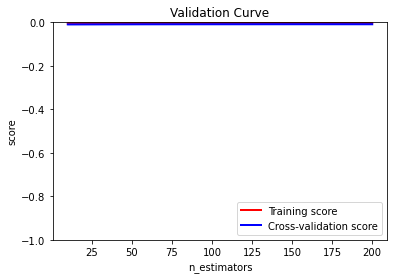

In [166]:
random_forest_plotter = GridSearchPlotter(random_forest_search_pipe.steps[-1][1])
random_forest_plotter.plot_validation_curve(parameter='n_estimators',ylim=(-1,0))

In [168]:
random_forest_search_pipe.steps[-1][1].best_score_

-0.007844459940872944

In [169]:
random_forest_search_pipe.steps[-1][1].best_params_

{'n_estimators': 152}

In [170]:
random_forest_pipe.fit(X_tr,np.log(y_tr).values.astype(np.float32))

/Users/simonhelmig/anaconda3/envs/tabnet-test/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('preprocessing', Pipeline(memory=None,
     steps=[('running_time_imputer', RunningTimeImputer(number_of_tracks='number_of_tracks',
          running_time='running_time')), ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist', 'label', 'format_text', 'format_name', 'master_id'],
    ...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [171]:
random_forest_tr_pred = random_forest_pipe.predict(X_tr)
random_forest_te_pred = random_forest_pipe.predict(X_te)

In [172]:
r2_score(y_tr,np.exp(random_forest_tr_pred))

-0.0737017008450278

In [173]:
r2_score(y_te,np.exp(random_forest_te_pred))

-0.07603848407232161

In [174]:
mean_absolute_error(y_tr,np.exp(random_forest_tr_pred))

10.475589148356317

In [175]:
mean_absolute_error(y_te,np.exp(random_forest_te_pred))

10.503775444214748

## Catboost

In [181]:
record_store_catboost_removal_columns = [
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title'
    ]
#record_store_catboost_removal_columns.extend(
#    column_store._indicator
#)

In [14]:
catboost_param_grid = {
        'depth': np.linspace(1,16,5).astype(int),
        'learning_rate' : np.logspace(-4,-1,5),
        'l2_leaf_reg': np.linspace(1,50,5).astype(int),
        'iterations': np.linspace(50,250,3),
        'n_estimators': np.linspace(20,200,5).astype(int)
}

In [70]:
np.logspace(-1,0,10)

array([0.1       , 0.12915497, 0.16681005, 0.21544347, 0.27825594,
       0.35938137, 0.46415888, 0.59948425, 0.77426368, 1.        ])

In [182]:
catboost_processing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    #('reduce_indicators', IndicatorReducer(indicators=column_store._indicator-column_store._geography,algorithm=PCA,components=40)),
    ('record_store_column_remover', ColumnRemover(record_store_catboost_removal_columns))
])

catboost = CatBoostRegressor(
    random_seed=0,
    cat_features=['year','format_text','master_id','format_name','artist','label','country'],
    boosting_type='Ordered',
    n_estimators=100,
    learning_rate=0.16681005,
    l2_leaf_reg=3,
    border_count=170,
    max_depth=10
)

catboost_grid_pipe = Pipeline([
    ('processing', catboost_processing_pipe),
    ('grid_search', GridSearchCV(
        catboost,
        param_grid={'max_depth': np.linspace(10,32,5).astype(int)},
        n_jobs=-1,
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=50,
        return_train_score=True
    )
    )
])

catboost_pipe = Pipeline([
    ('processing',catboost_processing_pipe),
    ('catboost',catboost)
])

In [130]:
catboost_grid_pipe.fit(X_tr_sample,np.log(y_tr_sample))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  1.8min remaining:   48.4s
[Parallel(n_jobs=-1)]: Done  12 out of  16 | elapsed:  1.8min remaining:   35.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  1.8min remaining:   24.6s
[

KeyboardInterrupt: 

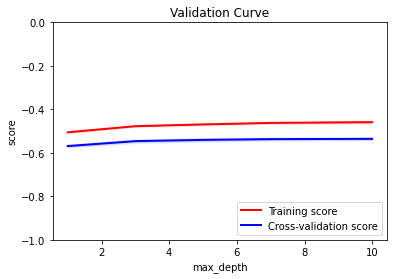

In [126]:
catboost_plot = GridSearchPlotter(catboost_grid_pipe.steps[-1][1])
catboost_plot.plot_validation_curve(parameter='max_depth',ylim=(-1,0))

In [127]:
catboost_grid_pipe.steps[-1][1].best_score_

-0.5352998262230626

In [128]:
catboost_grid_pipe.steps[-1][1].best_params_

{'max_depth': 10}

In [183]:
catboost_pipe.fit(X_tr,np.log(y_tr))

0:	learn: 0.8568389	total: 836ms	remaining: 1m 22s
1:	learn: 0.8288709	total: 1.62s	remaining: 1m 19s
2:	learn: 0.8032412	total: 2.41s	remaining: 1m 17s
3:	learn: 0.7839949	total: 3.17s	remaining: 1m 16s
4:	learn: 0.7692235	total: 3.89s	remaining: 1m 14s
5:	learn: 0.7584706	total: 4.62s	remaining: 1m 12s
6:	learn: 0.7439335	total: 5.33s	remaining: 1m 10s
7:	learn: 0.7331414	total: 6.04s	remaining: 1m 9s
8:	learn: 0.7245243	total: 6.74s	remaining: 1m 8s
9:	learn: 0.7185029	total: 7.45s	remaining: 1m 7s
10:	learn: 0.7136388	total: 8.16s	remaining: 1m 6s
11:	learn: 0.7092430	total: 8.87s	remaining: 1m 5s
12:	learn: 0.7059718	total: 9.57s	remaining: 1m 4s
13:	learn: 0.7033156	total: 10.3s	remaining: 1m 3s
14:	learn: 0.7009290	total: 11s	remaining: 1m 2s
15:	learn: 0.6979617	total: 11.7s	remaining: 1m 1s
16:	learn: 0.6958002	total: 12.4s	remaining: 1m
17:	learn: 0.6938155	total: 13.1s	remaining: 59.7s
18:	learn: 0.6926843	total: 13.8s	remaining: 58.8s
19:	learn: 0.6914857	total: 14.5s	remai

Pipeline(memory=None,
     steps=[('processing', Pipeline(memory=None,
     steps=[('running_time_imputer', RunningTimeImputer(number_of_tracks='number_of_tracks',
          running_time='running_time')), ('record_store_column_remover', ColumnRemover(cols_to_remove=['market_price', 'units_for_sale', 'have', 'want', 'average_r...ce_last_sale', 'title']))])), ('catboost', <catboost.core.CatBoostRegressor object at 0x15e4160b8>)])

In [184]:
catboost_tr_pred = catboost_pipe.predict(X_tr)
catboost_te_pred = catboost_pipe.predict(X_te)

In [185]:
r2_score(y_tr,np.exp(catboost_tr_pred))

0.2743421962986967

In [186]:
r2_score(y_te,np.exp(catboost_te_pred))

0.22087295555116782

In [187]:
mean_absolute_error(y_tr,np.exp(catboost_tr_pred))

7.590262150675475

In [188]:
mean_absolute_error(y_te,np.exp(catboost_te_pred))

8.133444466554486